# Test Model

In [7]:
import numpy as np

from active import split_on_ids
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from pymks import (
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
)

from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [8]:
def make_gp_model_matern():
    kernel = Matern(length_scale=1.0, nu=0.5)
#    kernel = 0.5 * RBF(length_scale=1) + WhiteKernel(noise_level=1)
    regressor = GaussianProcessRegressor(kernel=kernel)
    return regressor

def make_linear_model():
    return Pipeline(steps=(
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', LinearRegression()),
    ))


In [9]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

In [10]:
def train_test_split_(x_data, y_data, prop, random_state=None):
    ids = np.random.choice(len(x_data), int(prop * len(x_data)), replace=False)
    x_0, x_1 = split_on_ids(x_data, ids)
    y_0, y_1 = split_on_ids(y_data, ids)
    return x_0, x_1, y_0, y_1

In [11]:
def split(x_data, y_data, train_sizes=(0.9, 0.09), random_state=None):
    x_pool, x_, y_pool, y_ = train_test_split_(
        x_data,
        y_data,
        train_sizes[0],
        random_state=random_state
    )
    x_test, x_calibrate, y_test, y_calibrate = train_test_split_(
        x_,
        y_,
        train_sizes[1] / (1 - train_sizes[0]),
        random_state=random_state
    ) 
    return x_pool, x_test, x_calibrate, y_pool, y_test, y_calibrate

In [17]:
data = np.load('run_00000005/data-pca.npz')

In [18]:
x_data_pca = data['x_data_pca'][:]
y_data = data['y_data']

In [19]:
x_pool, x_test, x_train, y_pool, y_test, y_train = split(x_data_pca, y_data, (0.6, 0.2))

In [20]:
x_train.shape

(100, 15)

In [21]:
x_test.shape

(100, 15)

In [22]:
#model = make_linear_model()
model = make_gp_model_matern()

In [23]:
model.fit(x_train, y_train)

/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=0.5))

In [24]:
y_train_predict = model.predict(x_train)

In [25]:
y_test_predict = model.predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

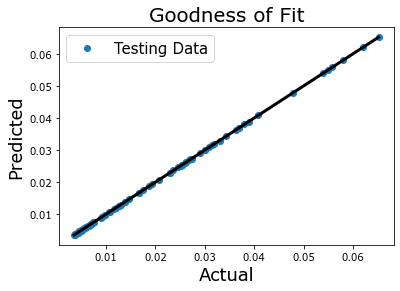

In [26]:
plot_parity(y_train, y_train_predict)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

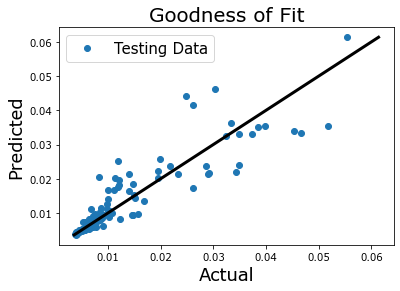

In [27]:
plot_parity(y_test, y_test_predict)

In [28]:
print(r2_score(y_test, y_test_predict))
#print(y_test.shape)
#print(y_test)
print(model.score(x_test, y_test))
#sklearn.metrics.r2_score()

0.7866500642659504
0.7866500642659504


In [29]:
scores = []
for _ in range(40):
    x_pool, x_test, x_train, y_pool, y_test, y_train = split(x_data_pca, y_data, (0.0, 0.2))
    model = make_gp_model_matern()
    model.fit(x_train, y_train)
    print(x_train.shape)
    scores += [model.score(x_test, y_test)]
    
print(scores)

/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/skle

(400, 15)
(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/skle

(400, 15)
(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
(400, 15)
(400, 15)


/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \
/nix/store/h3jg5jg3iv8gxqb2hhfrvxnr3bb4dcah-python3.8-scikit-learn-0.23.2/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1623: RuntimeWarning: invalid value encountered in true_divide
  K_gradient = K[..., np.newaxis] * D \


(400, 15)
[0.8578969185665903, 0.9015503612285942, 0.8776151033138324, 0.9036828115858819, 0.940333173169795, 0.9290108666112127, 0.9443881071165511, 0.9278419991486242, 0.9057740571319699, 0.9370544215107524, 0.9258148207915172, 0.8991611006949676, 0.9118247109740596, 0.8589537598174053, 0.935815943973958, 0.9087158797109762, 0.929015289611213, 0.903961496784483, 0.9330544047046774, 0.9231600949876522, 0.9624389786987799, 0.9261069194916449, 0.9439103717172437, 0.9443454131404917, 0.9002121251139757, 0.9130699634650672, 0.9565055388057844, 0.9394651812713659, 0.9480609188107194, 0.9319624580765934, 0.9301673967362183, 0.9367742055643944, 0.9450383947111044, 0.9217889340346676, 0.9028403459802115, 0.9510380288736908, 0.9063682019511538, 0.9139693565645883, 0.9402476499262282, 0.8792517758233341]


In [30]:
np.mean(scores)

0.9212046870047992

In [31]:
np.std(scores)

0.02431749379410985